In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [2]:
def generate_synthetic_data(num_samples, input_dim):
    data = np.random.randn(num_samples, input_dim)
    return torch.tensor(data, dtype=torch.float32)

In [3]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

In [4]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [5]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [6]:
def loss_function(recon_x, x, mu, logvar, beta=0.1):
    BCE = nn.functional.mse_loss(recon_x, x, reduction='mean')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD

In [7]:
# Hyperparameters
batch_size = 64
learning_rate = 0.0001
num_epochs = 10
input_dim = 100
hidden_dim = 32
latent_dim = 10
num_samples = 1000

In [8]:
synthetic_data = generate_synthetic_data(num_samples, input_dim)
data_loader = torch.utils.data.DataLoader(synthetic_data, batch_size=batch_size, shuffle=True)

In [9]:
vae = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

In [10]:
# Training Loop
for epoch in range(num_epochs):
    vae.train()
    train_loss = 0
    for i, data in enumerate(data_loader):
        optimizer.zero_grad()
        recon_data, mu, logvar = vae(data)
        loss = loss_function(recon_data, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    avg_loss = train_loss / len(data_loader)  # Compute per epoch loss
    print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")
    
print("Training finished")

Epoch 1, Average Loss: 4.4952
Epoch 2, Average Loss: 4.2336
Epoch 3, Average Loss: 4.0062
Epoch 4, Average Loss: 3.7988
Epoch 5, Average Loss: 3.6127
Epoch 6, Average Loss: 3.4454
Epoch 7, Average Loss: 3.2912
Epoch 8, Average Loss: 3.1519
Epoch 9, Average Loss: 3.0260
Epoch 10, Average Loss: 2.9099
Training finished


In [11]:
torch.save(vae.state_dict(), 'vae_model.pth')

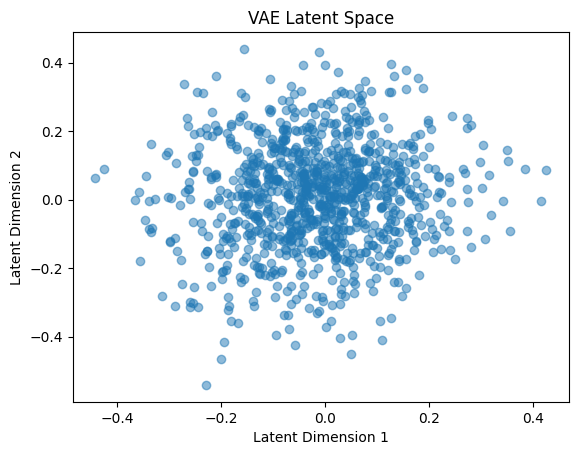

In [ ]:
import matplotlib.pyplot as plt

mu, logvar = vae.encoder(synthetic_data)
mu_np = mu.detach().numpy()
logvar_np = logvar.detach().numpy()
plt.scatter(mu_np[:, 0], mu_np[:, 1], alpha=0.5)
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("VAE Latent Space")
plt.show()
